In [44]:
import re
import numpy as np
import pandas as pd
import spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from gensim.parsing.porter import PorterStemmer
from pprint import pprint
from nltk.corpus import stopwords

# Download necessary data and models
import nltk
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')

# Read in the data
df = pd.read_excel('/content/Digital Twin.xlsx', index_col=0)
df = df.drop_duplicates(subset='Abstract', keep='first').reset_index(drop=True)

# Define stop words
stop_words = stopwords.words('english')
stop_words.extend(['research','use','new','article','study','model','define','background','examine','paper',
                   'eaxamination','ivestigate','aim','goal','objective','US','china','result',
                   'measure','measurment','quality','analysis','approach','method','propose','investigate'])

# Define pre-processing functions
def clean_text(text):
    ## Remove emails, numbers, and punctuation
    text = re.sub(r'\S*@\S*\s?', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Lowercase the text
    text = text.lower()
    # Remove new line characters
    text = re.sub(r'\s+', ' ', text)
    # Remove distracting single quotes
    text = re.sub(r"\'", "", text)
    return text

def tokenize(text):
    tokens = simple_preprocess(text, deacc=True, min_len=3)
    return [token for token in tokens if token not in stop_words]

def make_bigrams(texts):
    bigram = Phrases(texts, min_count=10, threshold=50)
    bigram_phraser = Phraser(bigram)
    trigram = Phrases(bigram_phraser[texts], min_count=10, threshold=50)
    trigram_phraser = Phraser(trigram)
    return [trigram_phraser[bigram_phraser[doc]] for doc in texts]

def lemmatize(text, allowed_postags=['NOUN', 'VERB', 'ADJ', 'ADV']):
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ not in stop_words]

def stem(text):
    p = PorterStemmer()
    return [p.stem(token) for token in text]

# Pre-process the data
df['text'] = df['Abstract'].apply(clean_text)
df['tokens'] = df['text'].apply(tokenize)
df['bigrams'] = make_bigrams(df['tokens'])
df['lemmatized'] = df['bigrams'].apply(lambda x: lemmatize(' '.join(x)))
df['stemmed'] = df['lemmatized'].apply(stem)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
import gensim

# Create a list of lists of the cleaned tokens
text = df['stemmed'].tolist()

# Create a dictionary of the cleaned tokens
dictionary = gensim.corpora.Dictionary(text)
print('Total Vocabulary Size:', len(dictionary))

# Filter out words that occur less than 5 documents, or more than 90% of the documents.
dictionary.filter_extremes(no_below=2, no_above=0.7)
print('Total Vocabulary Size after removing:', len(dictionary))

# Create a bag-of-words corpus of the cleaned tokens
corpus = [dictionary.doc2bow(t) for t in text]

Total Vocabulary Size: 14510
Total Vocabulary Size after removing: 6929


In [46]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten the list of stemmed words
word_list_flattened = [word for sublist in text for word in sublist]

# Count the frequency of each word
word_counts = Counter(word_list_flattened)

# Get the top 20 keywords based on frequency
top_keywords = word_counts.most_common(20)


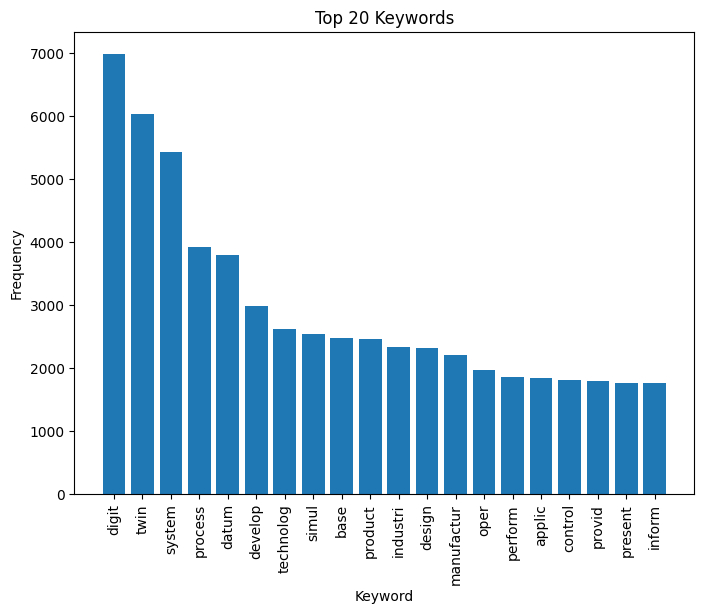

In [47]:
# Create a bar chart of the top keywords
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar([x[0] for x in top_keywords], [x[1] for x in top_keywords])
ax.set_title('Top 20 Keywords')
ax.set_xlabel('Keyword')
ax.set_ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [48]:
import gensim

# Set the number of topics to be generated
num_topics = 10

# Create an LDA model using the bag-of-words corpus and the filtered dictionary
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

# Print the top 10 words in each topic
for i, topic in lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    print('Topic {}: {}'.format(i, [word[0] for word in topic]))


Topic 0: ['product', 'assembl', 'process', 'system', 'control', 'base', 'predict', 'technolog', 'oper', 'datum']
Topic 1: ['industri', 'system', 'process', 'manufactur', 'develop', 'product', 'technolog', 'design', 'present', 'oper']
Topic 2: ['process', 'system', 'simul', 'datum', 'control', 'develop', 'predict', 'manufactur', 'base', 'oper']
Topic 3: ['metavers', 'technolog', 'system', 'develop', 'predict', 'simul', 'build', 'dynam', 'perform', 'compar']
Topic 4: ['datum', 'system', 'inform', 'develop', 'oper', 'build', 'energi', 'construct', 'base', 'process']
Topic 5: ['structur', 'datum', 'predict', 'simul', 'base', 'patient', 'develop', 'perform', 'paramet', 'comput']
Topic 6: ['process', 'system', 'datum', 'simul', 'base', 'develop', 'perform', 'paramet', 'structur', 'oper']
Topic 7: ['datum', 'process', 'system', 'technolog', 'base', 'intellig', 'applic', 'present', 'oper', 'develop']
Topic 8: ['system', 'design', 'process', 'manufactur', 'simul', 'product', 'develop', 'industr

In [49]:
import numpy as np
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Set the range of topics to explore
topic_range = list(range(2, 30, 1))

# Set the threshold for perplexity score
perplexity_threshold = 0.05

# Set the threshold for coherence score
coherence_threshold = 0.4

# Initialize variables
coherence_scores = []
perplexity_scores = []
max_coherence_index = -1
optimal_num_topics = -1
perplexity_threshold_index = -1
for num_topics in topic_range:
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)

    # Compute the coherence score for the LDA model
    coherence_model_lda = CoherenceModel(model=lda_model, texts=text, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()

    # Compute the perplexity score for the LDA model
    perplexity_score = lda_model.log_perplexity(corpus)

    # Store the coherence and perplexity scores
    coherence_scores.append(coherence_score)
    perplexity_scores.append(perplexity_score)

    # Print the coherence and perplexity scores for each topic
    print(f"Number of topics: {num_topics}")
    print(f"Perplexity score: {perplexity_score}")
    print(f"Coherence score: {coherence_score}\n")

    # Track the index of the maximum coherence score
    if coherence_score >= max(coherence_scores[max_coherence_index:], default=0):
        max_coherence_index = topic_range.index(num_topics)

    # Find the optimal number of topics based on perplexity score
    if abs(perplexity_score - np.exp(-perplexity_threshold)) <= perplexity_threshold:
        perplexity_threshold_index = topic_range.index(num_topics)

    # Find the optimal number of topics based on coherence score
    if coherence_score >= coherence_threshold and max_coherence_index != -1 and perplexity_threshold_index != -1:
        optimal_num_topics = topic_range[max_coherence_index:perplexity_threshold_index+1][np.argmax(coherence_scores[max_coherence_index:perplexity_threshold_index+1])]

if optimal_num_topics != -1:
    print('Optimal number of topics:', optimal_num_topics)
else:
    print('Unable to find optimal number of topics')


Number of topics: 2
Perplexity score: -7.332285982264419
Coherence score: 0.326163116053489

Number of topics: 3
Perplexity score: -7.3135198875189324
Coherence score: 0.30686552667523176

Number of topics: 4
Perplexity score: -7.311948644369877
Coherence score: 0.3326073099735026

Number of topics: 5
Perplexity score: -7.330820290571604
Coherence score: 0.37694109073908877

Number of topics: 6
Perplexity score: -7.346265938263495
Coherence score: 0.30637868188754286

Number of topics: 7
Perplexity score: -7.358522834349466
Coherence score: 0.315615439257109

Number of topics: 8
Perplexity score: -7.3772808239859815
Coherence score: 0.34309199562527287

Number of topics: 9
Perplexity score: -7.443851761212611
Coherence score: 0.33687910962874745

Number of topics: 10
Perplexity score: -7.5548490997990045
Coherence score: 0.34742263598016226

Number of topics: 11
Perplexity score: -7.76609721521179
Coherence score: 0.33946750133985787

Number of topics: 12
Perplexity score: -8.156601238

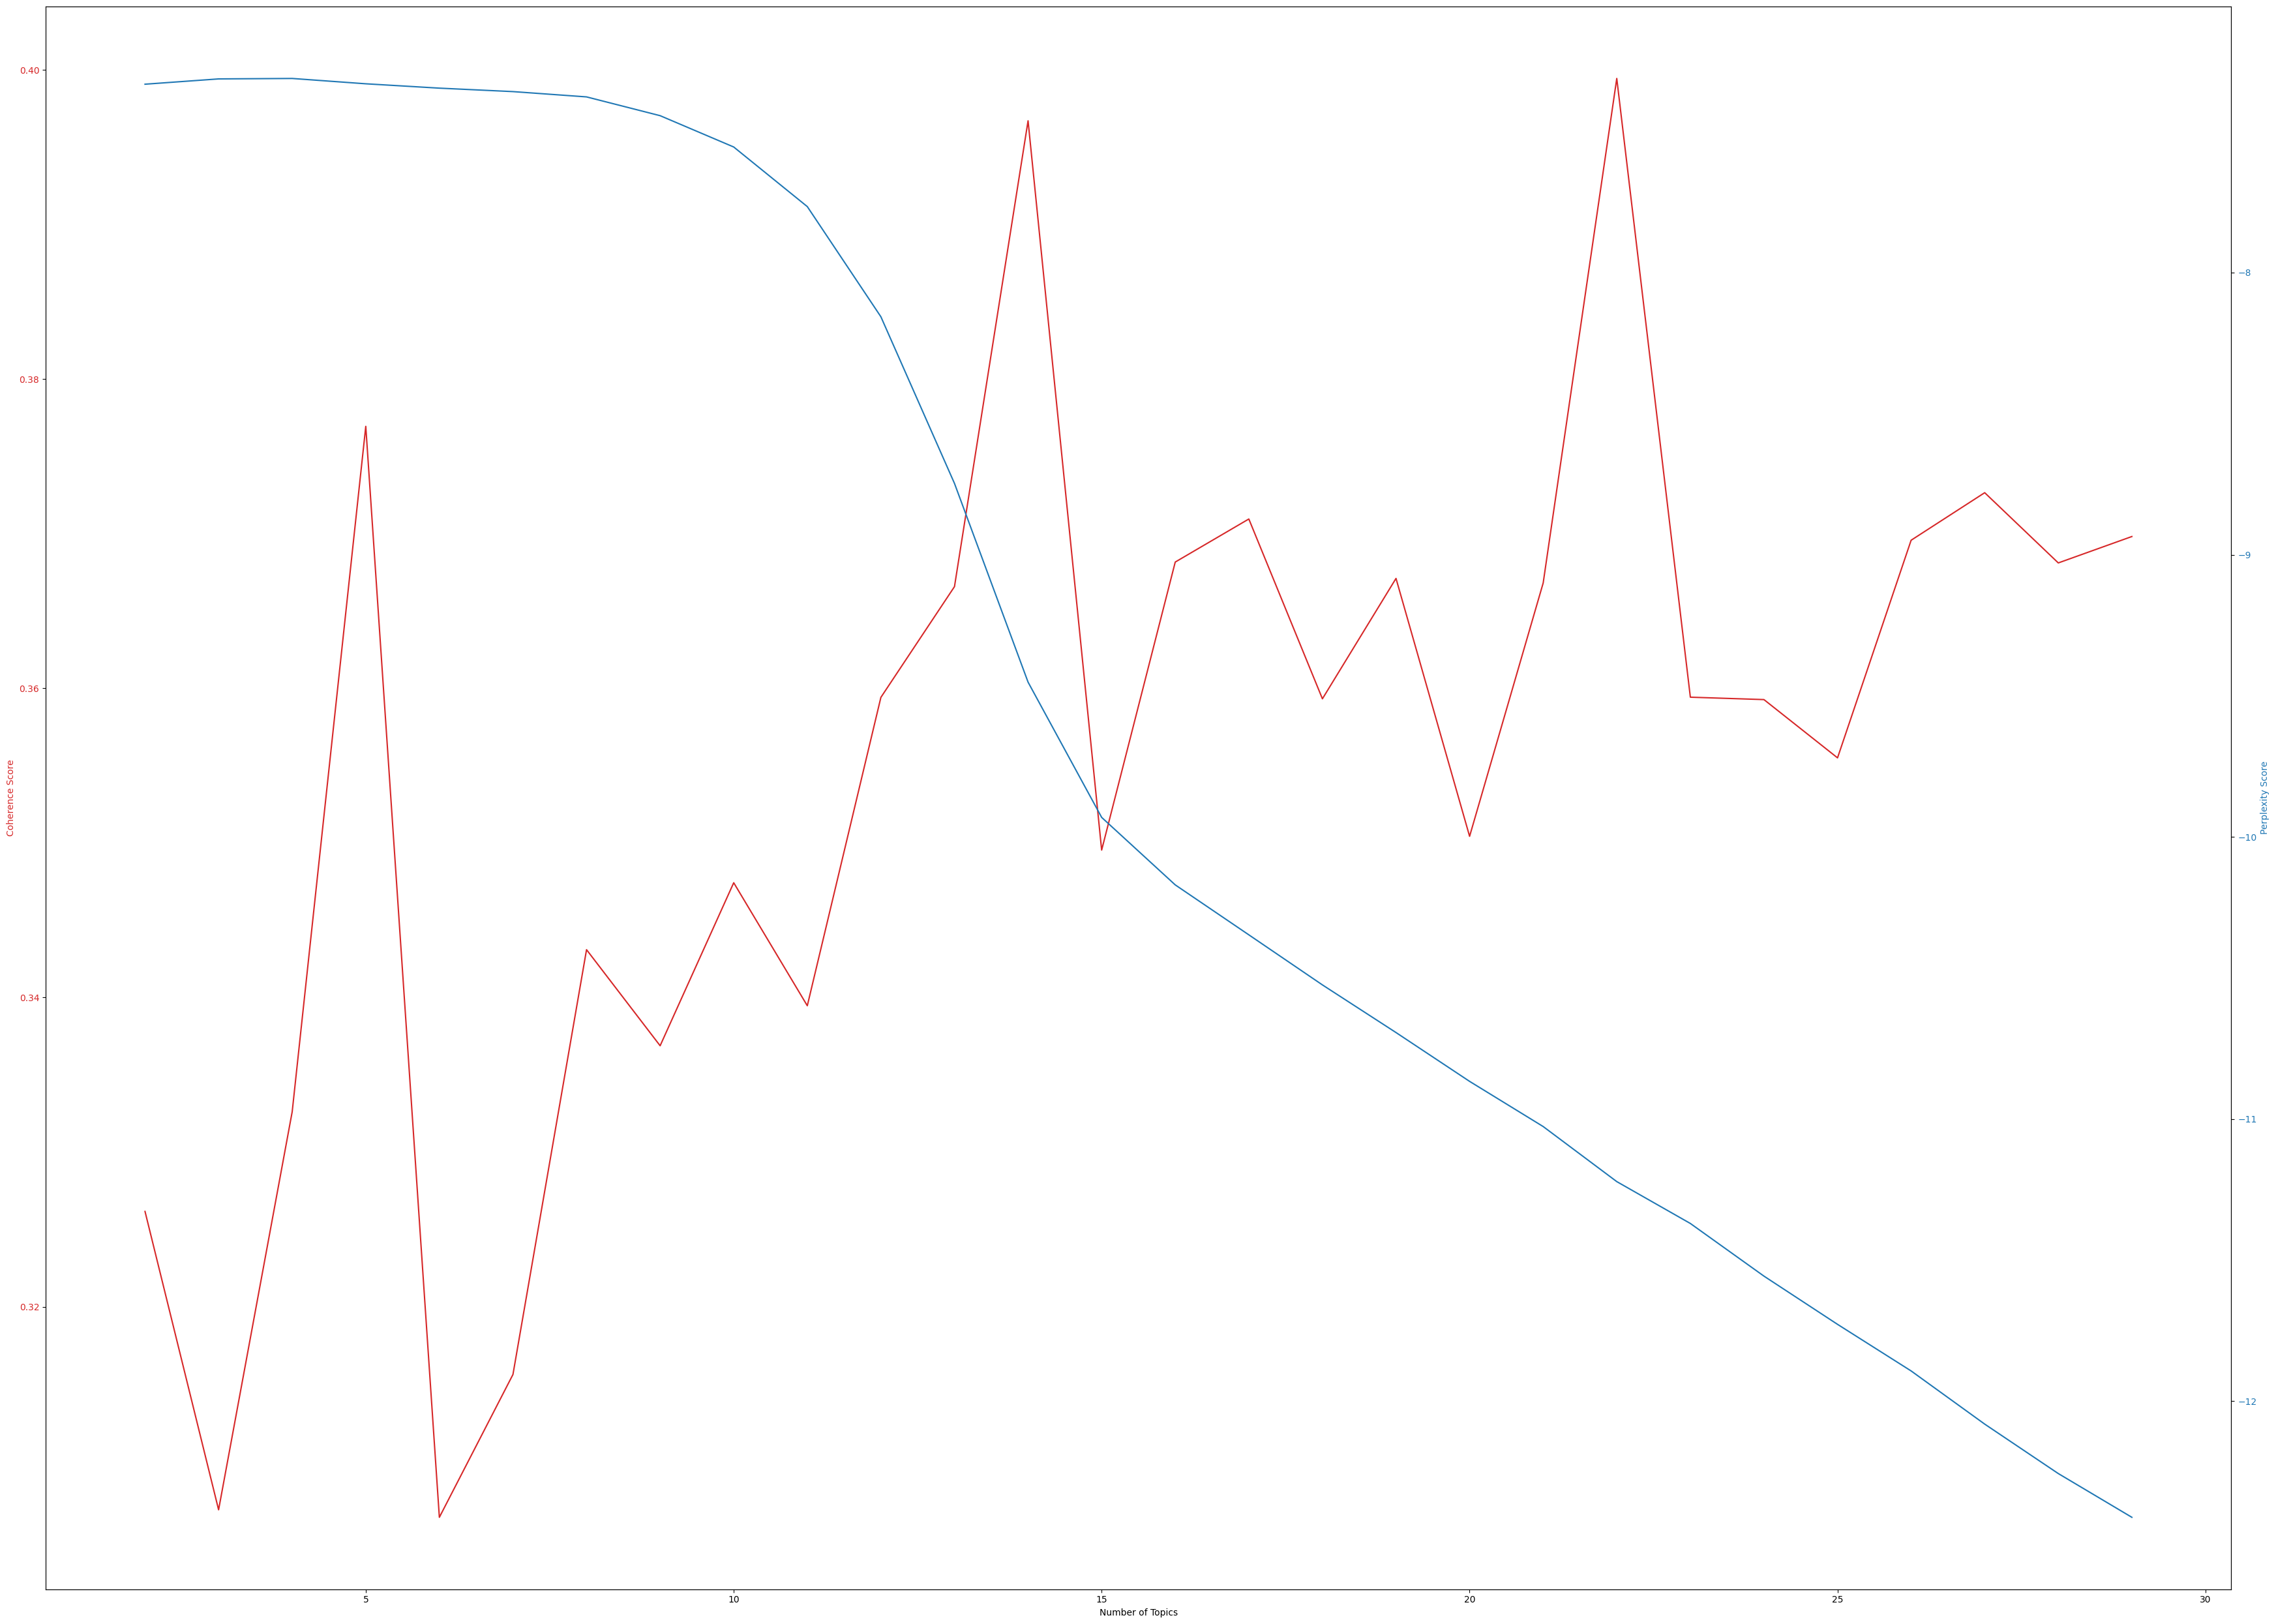

In [50]:
# Plot the results
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence Score', color=color)
ax1.plot(topic_range, coherence_scores, color=color, label='Coherence Score')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Perplexity Score', color=color) 
ax2.plot(topic_range, perplexity_scores, color=color, label='Perplexity Score')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

In [78]:
# Train an LDA model with the optimal number of topics
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=15,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)
for topic in lda_model.print_topics():
    print(topic)

(0, '0.054*"datum" + 0.047*"simul" + 0.032*"paramet" + 0.031*"monitor" + 0.027*"structur" + 0.020*"estim" + 0.020*"observ" + 0.019*"obtain" + 0.019*"dynam" + 0.016*"sensor"')
(1, '0.341*"sustain" + 0.078*"ship" + 0.069*"dt" + 0.066*"govern" + 0.035*"green" + 0.022*"european" + 0.022*"orchestr" + 0.017*"cosimul" + 0.013*"upcom" + 0.012*"agentbas"')
(2, '0.023*"differ" + 0.018*"perform" + 0.016*"effect" + 0.015*"oper" + 0.015*"show" + 0.014*"case" + 0.013*"develop" + 0.013*"factor" + 0.012*"high" + 0.011*"test"')
(3, '0.157*"predict" + 0.077*"surfac" + 0.051*"machin" + 0.048*"error" + 0.047*"part" + 0.035*"influenc" + 0.032*"accuraci" + 0.030*"curvatur" + 0.027*"geometri" + 0.027*"geometr"')
(4, '0.127*"robot" + 0.064*"cell" + 0.057*"program" + 0.040*"spatial" + 0.040*"educ" + 0.039*"manual" + 0.036*"orient" + 0.030*"task" + 0.026*"student" + 0.024*"manipul"')
(5, '0.029*"technolog" + 0.025*"develop" + 0.022*"case" + 0.021*"industri" + 0.017*"applic" + 0.016*"datum" + 0.015*"build" + 0.0

In [79]:
lda_model.save('lda_model')
# Load the LDA model from the specified file path
lda_model = LdaModel.load('lda_model')

In [80]:
topics = [[(term, round(wt, 3)) for term, wt in lda_model.show_topic(n, topn=25)] for n in range(0, lda_model.num_topics)]
topics

[[('datum', 0.054),
  ('simul', 0.047),
  ('paramet', 0.032),
  ('monitor', 0.031),
  ('structur', 0.027),
  ('estim', 0.02),
  ('observ', 0.02),
  ('obtain', 0.019),
  ('dynam', 0.019),
  ('sensor', 0.016),
  ('experiment', 0.016),
  ('state', 0.016),
  ('measur', 0.015),
  ('calcul', 0.014),
  ('flow', 0.014),
  ('mathemat', 0.013),
  ('respons', 0.013),
  ('accur', 0.011),
  ('condit', 0.011),
  ('detect', 0.01),
  ('temperatur', 0.01),
  ('caus', 0.01),
  ('devic', 0.01),
  ('sampl', 0.01),
  ('mode', 0.01)],
 [('sustain', 0.341),
  ('ship', 0.078),
  ('dt', 0.069),
  ('govern', 0.066),
  ('green', 0.035),
  ('european', 0.022),
  ('orchestr', 0.022),
  ('cosimul', 0.017),
  ('upcom', 0.013),
  ('agentbas', 0.012),
  ('best_practic', 0.01),
  ('maritim', 0.01),
  ('added_valu', 0.009),
  ('opinion', 0.008),
  ('play_important_rol', 0.008),
  ('perspect', 0.007),
  ('food', 0.0),
  ('water', 0.0),
  ('countri', 0.0),
  ('loss', 0.0),
  ('line', 0.0),
  ('behaviour', 0.0),
  ('circul

In [81]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 26)],
                         index=['Topic '+str(t) for t in range(1, lda_model.num_topics+1)]).T
topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15
Term1,datum,sustain,differ,predict,robot,technolog,ag,system,process,materi,design,network,train,central,patient
Term2,simul,ship,perform,surfac,cell,develop,imag,control,product,facil,construct,servic,learn,urban,len
Term3,paramet,dt,effect,machin,program,case,optic,manufactur,market,deform,virtual,stand,averag,damag,diagnosi
Term4,monitor,govern,oper,error,spatial,industri,sens,economi,optim,thoroughli,physic,transmiss,joint,plant,clinic
Term5,structur,green,show,part,educ,applic,batteri,implement,effici,strain,framework,vehicl,motion,citi,treatment


In [82]:
pd.set_option('display.max_colwidth', -1)

topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)] )
topics_df

<ipython-input-82-b0dbff8103b2>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"datum, simul, paramet, monitor, structur, estim, observ, obtain, dynam, sensor, experiment, state, measur, calcul, flow, mathemat, respons, accur, condit, detect, temperatur, caus, devic, sampl, mode"
Topic2,"sustain, ship, dt, govern, green, european, orchestr, cosimul, upcom, agentbas, best_practic, maritim, added_valu, opinion, play_important_rol, perspect, food, water, countri, loss, line, behaviour, circular_economi, bottom, tripl"
Topic3,"differ, perform, effect, oper, show, case, develop, factor, high, test, base, transit, great, increas, give, well, gener, present, evalu, size, assess, compar, open, energi, howev"
Topic4,"predict, surfac, machin, error, part, influenc, accuraci, curvatur, geometri, geometr, accur, measur, pressur, unit, disturb, output, vibrat, deviat, profil, discharg, surrog, neural_network, cycl, scan, adjust"
Topic5,"robot, cell, program, spatial, educ, manual, orient, task, student, manipul, human, investig, filter, class, grid, skill, contrast, evid, reproduc, hardwar, fabric, teach, desir, collis, cours"
Topic6,"technolog, develop, case, industri, applic, datum, build, inform, gap, shape, manag, challeng, provid, present, integr, implement, year, engin, practic, support, enabl, adopt, need, solut, emerg"
Topic7,"ag, imag, optic, sens, batteri, air, transport, valuabl, traffic, correl, previous_studi, logist, charg, stress, cell, video, unknown, rout, classic, game, registr, plane, fem, great, stochast"
Topic8,"system, control, manufactur, economi, implement, human, smart, intellig, industri, oper, architectur, environ, integr, autom, collabor, camera, develop, configur, flexibl, adapt, autonom, commun, factori, theoret, interfac"
Topic9,"process, product, market, optim, effici, cost, problem, improv, affect, oper, assembl, strategi, polit, reduc, base, plan, time, demand, equip, mainten, period, meet, task, progress, schedul"
Topic10,"materi, facil, deform, thoroughli, strain, curv, replac, induc, fractur, drop, versatil, stress, trial_error, stimulu, claim, hip, microstructur, grade, fiber, recoveri, occlus, failur, forc, loss, roll"


In [83]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", colormap="inferno",
               max_font_size=150, random_state=30)
plt.rcParams['figure.figsize'] = [35, 25]
# Create subplots for each topic
for i in range(15):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

Output hidden; open in https://colab.research.google.com to view.

In [84]:
import pandas as pd

# Create a list to store the dominant topics for each document
dominant_topics = []

# Loop through each document in the corpus
for i, doc in enumerate(corpus):
    # Get the dominant topic for the current document
    topic_probs = lda_model.get_document_topics(doc, minimum_probability=0.0)
    dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
    dominant_topics.append(dominant_topic)

# Create a Pandas dataframe containing the dominant topic for each document
df_dominant_topics = pd.DataFrame({'Dominant_Topic': dominant_topics})

# Concatenate the original dataset with the new dataframe
df_with_topics = pd.concat([df, df_dominant_topics], axis=1)


In [85]:
import numpy as np
import pandas as pd


# Assuming you have already created a list of dominant topics called "dominant_topics"
dominant_topic_df = pd.DataFrame({'Dominant Topic': dominant_topics})

# Group by dominant topic and calculate document count and percentage of total documents
dominant_topic_df = dominant_topic_df.groupby('Dominant Topic').agg(
    Doc_Count=('Dominant Topic', np.size),
    Total_Docs_Perc=('Dominant Topic', np.size)).reset_index()

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus), 2))

# This will give you a dataframe with the following columns:
# Dominant Topic: the topic number
# Doc_Count: the number of documents with that dominant topic
# Total_Docs_Perc: the percentage of total documents with that dominant topic
dominant_topic_df

,Dominant Topic,Doc_Count,Total_Docs_Perc
0,0,262,6.89
1,2,1550,40.75
2,3,13,0.34
3,4,2,0.05
4,5,1617,42.51
5,6,2,0.05
6,7,39,1.03
7,8,141,3.71
8,10,165,4.34
9,11,10,0.26


In [86]:
# Create a list to store the dominant topics and their corresponding probabilities for each document
dominant_topics = []

# Loop through each document in the corpus
for doc in corpus:
    # Get the dominant topic and its probability for the current document
    topic_probs = lda_model.get_document_topics(doc, minimum_probability=0.0)
    dominant_topic, contribution = max(topic_probs, key=lambda x: x[1])
    dominant_topics.append((dominant_topic, contribution))

# Create a Pandas dataframe containing the dominant topic and its contribution percentage for each document
df_dominant_topics = pd.DataFrame(dominant_topics, columns=['Dominant_Topic', 'Contribution %'])

# Group the dataframe by dominant topic and keep only the row with highest contribution percentage
dominant_topic_df = df_dominant_topics.groupby('Dominant_Topic').apply(lambda x: x.loc[x['Contribution %'].idxmax()]).reset_index(drop=True)
dominant_topic_df

,Dominant_Topic,Contribution %
0,0.0,0.468574
1,2.0,0.624388
2,3.0,0.395583
3,4.0,0.365418
4,5.0,0.686853
5,6.0,0.285326
6,7.0,0.335151
7,8.0,0.407978
8,10.0,0.479314
9,11.0,0.308443


In [87]:
# Create an empty list to store the dominant topics and their corresponding probabilities for each document
dominant_topics = []

# Loop through each document in the corpus
for doc in corpus:
    # Get the dominant topic and its probability for the current document
    topic_probs = lda_model.get_document_topics(doc, minimum_probability=0.0)
    dominant_topic, contribution = max(topic_probs, key=lambda x: x[1])
    dominant_topics.append([contribution for _, contribution in topic_probs])

# Create a Pandas DataFrame containing the dominant topic weights for each document
df_weights = pd.DataFrame(dominant_topics, columns=['Topic ' + str(i) for i in range(1, 16)])

# Print the DataFrame
print(df_weights)


       Topic 1   Topic 2   Topic 3   Topic 4   Topic 5   Topic 6   Topic 7  \
0     0.154726  0.001521  0.117247  0.008303  0.005568  0.410397  0.004972   
1     0.107347  0.000968  0.096339  0.005265  0.101091  0.065069  0.003197   
2     0.047288  0.001500  0.200910  0.008117  0.005492  0.373399  0.004904   
3     0.157191  0.001230  0.378191  0.018031  0.004613  0.190889  0.015292   
4     0.100331  0.001013  0.114121  0.023965  0.029274  0.128721  0.003316   
...        ...       ...       ...       ...       ...       ...       ...   
3799  0.263097  0.001003  0.274458  0.024936  0.003673  0.141344  0.003280   
3800  0.260591  0.000701  0.181704  0.003863  0.002605  0.246358  0.002290   
3801  0.066978  0.000828  0.336822  0.054483  0.036729  0.220437  0.113677   
3802  0.030583  0.000705  0.624387  0.003854  0.002585  0.041847  0.008938   
3803  0.035335  0.001012  0.360271  0.029027  0.003705  0.243486  0.012585   

       Topic 8   Topic 9  Topic 10  Topic 11  Topic 12  Topic 1

In [61]:
df_weights['Year'] = df.Year

In [62]:
df_weights.groupby('Year').mean()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15
Year,,,,,,,,,,,,,,,
2000,0.019512,0.015422,0.063783,0.013145,0.315595,0.067160,0.004160,0.003403,0.145261,0.003242,0.147023,0.003841,0.074619,0.088941,0.034892
2002,0.109960,0.036865,0.043824,0.021123,0.357876,0.013453,0.003520,0.002879,0.122022,0.025911,0.173118,0.003250,0.009196,0.070292,0.006712
2004,0.059757,0.056989,0.084745,0.008542,0.301582,0.025009,0.003532,0.002890,0.166299,0.017799,0.138213,0.003261,0.018000,0.105762,0.007618
2005,0.047169,0.006776,0.036353,0.045806,0.287741,0.057518,0.003283,0.002686,0.188369,0.016545,0.188841,0.003031,0.030790,0.078825,0.006267
2006,0.019436,0.069011,0.012456,0.037231,0.518804,0.015448,0.004954,0.004053,0.111551,0.003773,0.070451,0.025773,0.004060,0.090280,0.012720
2007,0.026489,0.026925,0.054254,0.020040,0.272854,0.101966,0.003531,0.002889,0.161882,0.002689,0.198638,0.007523,0.045905,0.064798,0.009617
2008,0.028405,0.007045,0.031897,0.050177,0.315257,0.052108,0.003269,0.002657,0.171823,0.002502,0.117729,0.012228,0.007323,0.172987,0.024593
2009,0.051368,0.014473,0.026041,0.020063,0.430752,0.040622,0.003550,0.002905,0.154197,0.002737,0.103903,0.007516,0.002910,0.122255,0.016709
2010,0.023090,0.011138,0.055634,0.029983,0.484839,0.015953,0.004479,0.003731,0.195244,0.003542,0.036780,0.042463,0.003670,0.080765,0.008690


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15
Year,,,,,,,,,,,,,,,
2000,0.019512,0.015422,0.063783,0.013145,0.315595,0.067160,0.004160,0.003403,0.145261,0.003242,0.147023,0.003841,0.074619,0.088941,0.034892
2002,0.109960,0.036865,0.043824,0.021123,0.357876,0.013453,0.003520,0.002879,0.122022,0.025911,0.173118,0.003250,0.009196,0.070292,0.006712
2004,0.059757,0.056989,0.084745,0.008542,0.301582,0.025009,0.003532,0.002890,0.166299,0.017799,0.138213,0.003261,0.018000,0.105762,0.007618
2005,0.047169,0.006776,0.036353,0.045806,0.287741,0.057518,0.003283,0.002686,0.188369,0.016545,0.188841,0.003031,0.030790,0.078825,0.006267
2006,0.019436,0.069011,0.012456,0.037231,0.518804,0.015448,0.004954,0.004053,0.111551,0.003773,0.070451,0.025773,0.004060,0.090280,0.012720
2007,0.026489,0.026925,0.054254,0.020040,0.272854,0.101966,0.003531,0.002889,0.161882,0.002689,0.198638,0.007523,0.045905,0.064798,0.009617
2008,0.028405,0.007045,0.031897,0.050177,0.315257,0.052108,0.003269,0.002657,0.171823,0.002502,0.117729,0.012228,0.007323,0.172987,0.024593
2009,0.051368,0.014473,0.026041,0.020063,0.430752,0.040622,0.003550,0.002905,0.154197,0.002737,0.103903,0.007516,0.002910,0.122255,0.016709
2010,0.023090,0.011138,0.055634,0.029983,0.484839,0.015953,0.004479,0.003731,0.195244,0.003542,0.036780,0.042463,0.003670,0.080765,0.008690


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15
Year,,,,,,,,,,,,,,,
2000,0.027885,0.006730,0.006417,0.033056,0.025826,0.024023,0.066663,0.007480,0.004375,0.219908,0.162000,0.022472,0.148568,0.151214,0.093385
2002,0.070472,0.011929,0.005488,0.025744,0.005493,0.043392,0.027779,0.060114,0.032924,0.194852,0.086273,0.004498,0.133622,0.248257,0.049162
2004,0.157048,0.005792,0.005417,0.013410,0.006135,0.005837,0.007142,0.023415,0.018395,0.284400,0.095263,0.019173,0.193659,0.148385,0.016529
2005,0.066190,0.005352,0.005088,0.062156,0.005190,0.032762,0.028922,0.034818,0.003478,0.202771,0.074839,0.031756,0.144593,0.221160,0.080926
2006,0.038182,0.007802,0.007357,0.023567,0.007832,0.007931,0.029259,0.026482,0.026205,0.206381,0.142650,0.006153,0.116572,0.284478,0.069149
2007,0.065549,0.010718,0.005570,0.051788,0.009775,0.040329,0.102349,0.016948,0.013418,0.248220,0.055063,0.019757,0.097332,0.201862,0.061323
2008,0.042400,0.010001,0.005020,0.027903,0.005085,0.014250,0.006498,0.005804,0.003431,0.358607,0.057471,0.022144,0.206677,0.139921,0.094789
2009,0.049809,0.005755,0.005417,0.029110,0.017122,0.018851,0.014561,0.010423,0.007785,0.229829,0.077155,0.004511,0.190304,0.296607,0.042760
2010,0.017153,0.025771,0.006811,0.042239,0.006940,0.007343,0.008891,0.008894,0.004697,0.250581,0.095538,0.005680,0.172321,0.222148,0.124993
